In [78]:
%reload_ext autoreload
%autoreload 2

In [79]:
from xai_cola import data_interface 
from xai_cola import ml_model_interface
from counterfactual_explainer import DiCE,DisCount
from xai_cola.cola_policy.matching import CounterfactualExactMatchingPolicy
from xai_cola.counterfactual_limited_actions import COLA

#### 0. Pick the data to be factual("Risk"=1)

In [80]:
from test_dataset.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
df = dataset.get_dataframe()
df.head(3)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,0
1,22,0,2,1,1,2,5951,48,5,1
2,49,1,1,1,1,0,2096,12,3,0


In [81]:
# pick 4 samples with Risk = 1
df_Risk_1 = df[df['Risk'] == 1]
df_Risk_1 = df_Risk_1.sample(8)

# drop the target column.
# Normally, the input data doesn't contain the target column
df_without_target = df_Risk_1.drop(columns=['Risk']).copy()
feature_names = df_without_target.columns
df_without_target.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
558,27,1,2,1,1,1,3552,24,4
914,31,1,2,2,1,1,3161,24,0
172,34,0,3,1,1,2,2064,24,4
585,20,0,2,2,1,1,2039,18,4
431,29,1,3,1,1,2,11328,24,7


#### 1. Initialize data interface

In [82]:
data = data_interface.PandasData(df_without_target, target_name='Risk')

#### 2. Initialize model interface

In [83]:
import joblib
lgbmcClassifier = joblib.load('lgbm_GremanCredit.pkl')
print(f'----lgbm_GremanCredit.pkl model has been loaded----')

----lgbm_GremanCredit.pkl model has been loaded----


In [84]:
ml_model = ml_model_interface.Model(model=lgbmcClassifier, backend="sklearn")

#### 3.Choose the CounterfactualExplanation Algorithm

In [85]:
explainer = DiCE(ml_model=ml_model)

In [86]:
factual, counterfactual = explainer.generate_counterfactuals(data=data,
                                                             factual_class=1,
                                                             total_cfs=1,
                                                             features_to_keep=['Age','Sex'])

100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


In [87]:
print(f'factual: {factual}')
print(f'counterfactual: {counterfactual}')

factual: [[   27     1     2     1     1     1  3552    24     4]
 [   31     1     2     2     1     1  3161    24     0]
 [   34     0     3     1     1     2  2064    24     4]
 [   20     0     2     2     1     1  2039    18     4]
 [   29     1     3     1     1     2 11328    24     7]
 [   22     0     2     1     2     1   741    12     2]
 [   24     0     2     2     1     1  1207    24     1]
 [   53     1     2     0     1     1  7119    48     4]]
counterfactual: [[   27     1     2     1     1     1  1886    24     4]
 [   31     1     2     2     1     1  3161    20     0]
 [   34     0     3     1     2     2  3077    24     4]
 [   20     0     2     2     1     1  9594    18     4]
 [   29     1     2     1     1     2  4852    24     7]
 [   22     0     2     1     2     2 10076    12     2]
 [   24     0     2     2     1     1  4342    19     1]
 [   53     1     3     0     1     1  7119    32     4]]


#### 4. Choose policy and make limitation

In [88]:
refiner = COLA(
            data=data,
            ml_model=ml_model,
            x_factual=factual,
            x_counterfactual=counterfactual,
            )
refiner.set_policy(
            matcher="ect",
            attributor="pshap",
            Avalues_method="max"
            )

You choose the Policy: pshap With Exact Matching, Avalues_method is max


In [96]:
""" Here! control the limited actions """
factual, ce, ace = refiner.get_refined_counterfactual(limited_actions=10)

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00657934  0.45727623]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.08316886 0.5122166 ]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.01224087 0.49576163]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.32306238 0.14459054]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.10539286 0.37734499]


#### 5.Highlight the generated counterfactuals

In [97]:
refine_factual, refine_ce, refine_ace = refiner.highlight_changes()

In [98]:
print("factual")
display(factual)
print("factaul -> corresponding counterfactual")
display(refine_ce)
print("factual -> action-limited counterfactual")
display(refine_ace)

factual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,27,1,2,1,1,1,3552,24,4,1
1,31,1,2,2,1,1,3161,24,0,1
2,34,0,3,1,1,2,2064,24,4,1
3,20,0,2,2,1,1,2039,18,4,1
4,29,1,3,1,1,2,11328,24,7,1
5,22,0,2,1,2,1,741,12,2,1
6,24,0,2,2,1,1,1207,24,1,1
7,53,1,2,0,1,1,7119,48,4,1


factaul -> corresponding counterfactual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,27,1,2,1,1,1,3552 -> 1886,24,4,1 -> 0
1,31,1,2,2,1,1,3161,24 -> 20,0,1 -> 0
2,34,0,3,1,1 -> 2,2,2064 -> 3077,24,4,1 -> 0
3,20,0,2,2,1,1,2039 -> 9594,18,4,1 -> 0
4,29,1,3 -> 2,1,1,2,11328 -> 4852,24,7,1 -> 0
5,22,0,2,1,2,1 -> 2,741 -> 10076,12,2,1 -> 0
6,24,0,2,2,1,1,1207 -> 4342,24 -> 19,1,1 -> 0
7,53,1,2 -> 3,0,1,1,7119,48 -> 32,4,1 -> 0


factual -> action-limited counterfactual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,27,1,2,1,1,1,3552 -> 1886,24,4,1 -> 0
1,31,1,2,2,1,1,3161,24 -> 20,0,1 -> 0
2,34,0,3,1,1,2,2064 -> 3077,24,4,1 -> 0
3,20,0,2,2,1,1,2039 -> 9594,18,4,1 -> 0
4,29,1,3,1,1,2,11328 -> 4852,24,7,1 -> 0
5,22,0,2,1,2,1,741 -> 10076,12,2,1 -> 0
6,24,0,2,2,1,1,1207 -> 4342,24 -> 19,1,1 -> 0
7,53,1,2 -> 3,0,1,1,7119,48 -> 32,4,1 -> 0


changes from factual to counterfactual


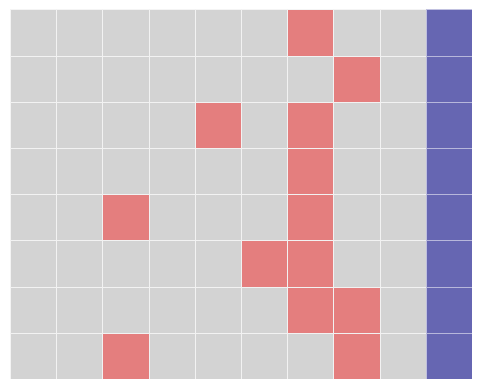

changes from factual to actionlimited_counterfactuals


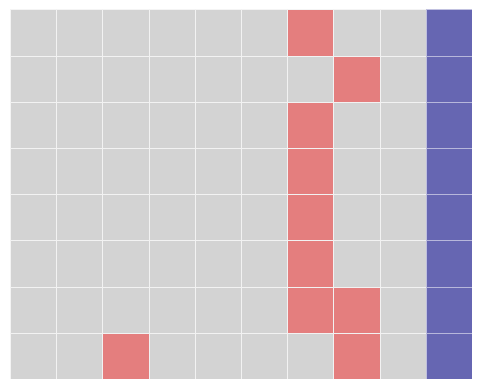

(None, None)

In [92]:
refiner.heatmap()